<a href="https://colab.research.google.com/github/porygon-tech/ECO/blob/main/structural_stability/tutorial_rohr2014Structural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/porygon-tech/ECO

Cloning into 'ECO'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 216 (delta 4), reused 11 (delta 3), pack-reused 200
Receiving objects: 100% (216/216), 1.53 MiB | 5.79 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [10]:
from os import chdir,getcwd
chdir('/content/ECO')
getcwd()

'/content/ECO'

In [11]:
import sys
sys.path.insert(0, "./lib")

In [12]:
import matriX as mX

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg

Specifically, the dynamical model has the following form

$$
\left\{\begin{array}{l}
\frac{d P_i}{d t}=P_i\left(\alpha_i^{(P)}-\sum_j \beta_{i j}^{(P)} P_j+\frac{\sum_j \gamma_{i j}^{(P)} A_j}{1+h \sum_j \gamma_{i j}^{(P)} A_j}\right) \\
\frac{d A_i}{d t}=A_i\left(\alpha_i^{(A)}-\sum_j \beta_{i j}^{(A)} A_j+\frac{\sum_j \gamma_{i j}^{(A)} P_j}{1+h \sum_j \gamma_{i j}^{(A)} P_j}\right)
\end{array}\right.
$$

In [14]:
def pdot (p,a,alpha_P,beta_P,gamma_P,h):
	gP_temp = np.sum(gamma_P*a.T)
	return p*(alpha_P - np.sum(beta_P*p.T) + gP_temp/(1+h*gP_temp))

def adot (a,p,alpha_A,beta_A,gamma_A,h):
	gA_temp = np.sum(gamma_A*p.T)
	return a*(alpha_A - np.sum(beta_A*a.T) + gA_temp/(1+h*gA_temp))

In [15]:
def showdata(mat, color=plt.cm.gnuplot, symmetry=False):
	mat = np.copy(mat)
	if symmetry:
		top = np.max([np.abs(np.nanmax(mat)),np.abs(np.nanmin(mat))])
		plt.imshow(mat.astype('float32'), interpolation='none', cmap='seismic',vmax=top,vmin=-top)
	else:
		plt.imshow(mat.astype('float32'), interpolation='none', cmap=color)
	plt.colorbar()
	plt.show()

In [16]:
n_P = 5
n_A = 9
h=0.1 # saturating constant of the beneficial effect of mutualisms, aka handling time. If h=0, the model becomes linear
time_delta=0.001

duration=10
ntimesteps=int(duration/time_delta)
p0 = np.random.randint(50,200,n_P)[:,np.newaxis].astype('float64')
a0 = np.random.randint(50,200,n_A)[:,np.newaxis].astype('float64')

In [17]:
alpha_P = np.random.rand(n_P)[:,np.newaxis]*2
beta_P  = np.random.rand(n_P,n_P)*0.1
gamma_P = np.random.rand(n_P,n_A)*5

alpha_A = np.random.rand(n_A)[:,np.newaxis]*4
beta_A  = np.random.rand(n_A,n_A)*0.1
gamma_A = np.random.rand(n_A,n_P)*5

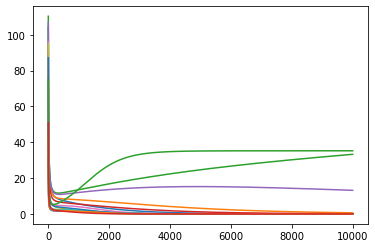

In [18]:
p = p0.copy()
a = a0.copy()
timeseries=np.zeros((n_P+n_A,ntimesteps))
for t in range(ntimesteps):
  p+=pdot(p,a,alpha_P,beta_P,gamma_P,h)*time_delta
  a+=adot(a,p,alpha_A,beta_A,gamma_A,h)*time_delta
  timeseries[:n_P ,t] = p.flatten()
  timeseries[ n_P:,t] = a.flatten()

fig = plt.figure(); ax = fig.add_subplot(111)
ax.plot(timeseries.T)
plt.show()

# Model of mutualism

In [19]:
#h       = 0   
rho     = 0.2 # interspecies competition (intraguild)
delta   = 0.5 # mutualistic trade off
gamma_0 = 0.2 # level of mutualistic strength

First, let's set the vector of growth rates

In [20]:
#alpha is the growth rate vector
alpha_A = np.random.normal(2,0.1,(n_A, 1))
alpha_P = np.random.normal(3,0.1,(n_P, 1))

#a is the growth rate vector
a = np.append(alpha_P,alpha_A,0)

In the absence of empirical information about interspecific competition, we use a mean field approximation for the competition parameters, where we set the diagonal elements of both $\beta$ matrices to 1 and the off-diagonals to $\rho<1$.

In [21]:
beta_A  = rho + np.zeros((n_A, n_A))
beta_P  = rho + np.zeros((n_P, n_P))

for i in range(n_A):
	beta_A[i,i]=1

for i in range(n_P):
	beta_P[i,i]=1

Now we create the bipartite network through a randomized matrix, where $y_{ij}=1$ if species $i$ and $j$ interact and zero otherwise.

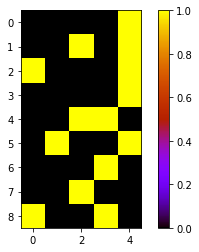

In [22]:
prob=0.4 #expected connectance
y = np.random.choice((0,1),(n_A,n_P), p=(1-prob, prob))
while np.any(y.sum(0)==0) or np.any(y.sum(1)==0):
    y = np.random.choice((0,1),(n_A,n_P), p=(1-prob, prob));
showdata(y)

As shown in a [previous study](https://www.nature.com/articles/ncomms3350?origin=ppub), the mutualistic benefit can be
further disentangled by
$\gamma_{i j}=\left(\gamma_0 y_{i j}\right) /\left(k_i^\delta\right)$

In [23]:
#k is the node degree
k_A=y.sum(1)[:,np.newaxis]
k_P=y.sum(0)[:,np.newaxis]

gamma_A = (gamma_0*y  )/k_A**delta
gamma_P = (gamma_0*y.T)/k_P**delta

# Stability condition



We investigated the conditions in our dynamical system that any feasible equilibrium point needs to satisfy to be globally stable. To derive these conditions, we started by studying the linear Lotka-Volterra approximation ($h=0$) of the dynamical model. In this linear approximation, the model reads

$$
\left[\begin{array}{l}
\frac{d P}{d t} \\
\frac{d A}{d t}
\end{array}\right]=\operatorname{diag}\left(\left[\begin{array}{l}
P \\
A
\end{array}\right]\right)
\times \left(\left[\begin{array}{l}
\alpha^{(P)} \\
\alpha^{(A)}
\end{array}\right]-\underbrace{\left[\begin{array}{cc}
\beta^{(P)} & -\gamma^{(P)} \\
-\gamma^{(A)} & \beta^{(A)}
\end{array}\right]}_{:=B}\left[\begin{array}{l}
P \\
A
\end{array}\right]\right)
$$

This ($h=0$) means that there is no saturating constant of the beneficial effect of mutualisms. Now with $\beta$ and $\gamma$ we can construct $B$, which is a two-by-two block matrix embedding all the interaction strengths.


$$ 
B=\left[\begin{array}{cc}
\beta^{(P)} & -\gamma^{(P)} \\
-\gamma^{(A)} & \beta^{(A)}
\end{array}\right]
$$

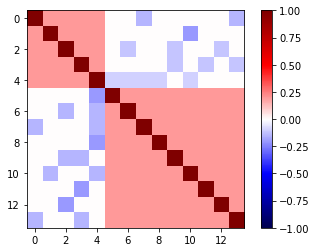

In [24]:
#B is the interaction matrix
B = np.append(np.append(beta_P,-gamma_P, axis=1), np.append(-gamma_A, beta_A,axis=1), axis=0); showdata(B,symmetry=True)

1.   For this model, it has been proved that an interaction matrix $B$ that is Lyapunov–diagonally stable grants the global stability of any potential feasible equilibrium.

2.   For some classes of matrices (symmetric matrices and Z-matrices, i.e. when off-diagonal elements are nonpositive), Lyapunov stability and Lyapunov diagonal stability are equivalent conditions. This makes it easier to test for Lyapunov diagonal stability, and therefore also for the property of granting global stability to any potential feasible equilibrium (Lyapunov diagonal stability is harder to check than Lyapunov stability).

3.   Our interaction strength matrix B is either symmetric when
the mutualistic trade-off is zero ($\delta = 0$) or is a Z-matrix when the interspecific competition is zero ($\rho = 0$).



In [25]:
if not (np.real(sparse.linalg.eigs(B,k=1,which='SM', return_eigenvectors=False))[-1] > 0):
    print("NOT ALL eigenvalues in the interaction matrix have positive real part, so no global stability can be guaranteed for feasible equilibrium points.")
else:
    print("ALL eigenvalues in the interaction matrix have positive real part, so a global stability can be guaranteed for feasible equilibrium points.")

ALL eigenvalues in the interaction matrix have positive real part, so a global stability can be guaranteed for feasible equilibrium points.


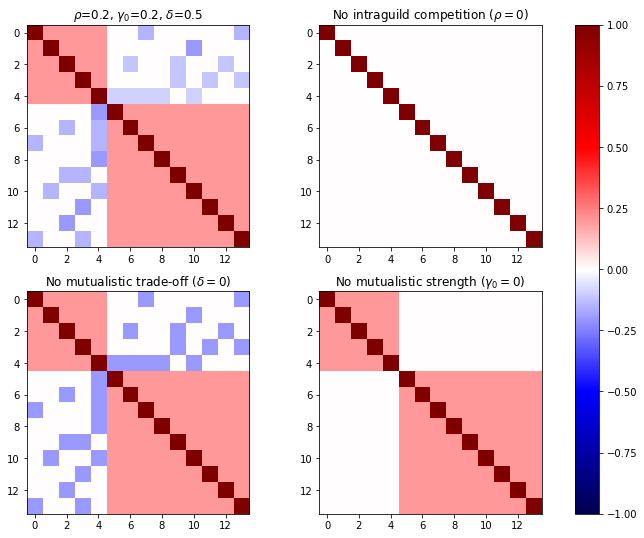

In [30]:

fig = plt.figure(figsize=(12,9))
#-----------------------------------------

mat = B.copy();

ax = fig.add_subplot(221)
top = np.max([np.abs(np.nanmax(mat)),np.abs(np.nanmin(mat))])
pcm = ax.imshow(mat.astype('float32'), interpolation='none', cmap='seismic',vmax=top,vmin=-top)
#fig.colorbar(pcm, ax=ax)
ax.set_title('$\\rho$=' + str(rho) + ', $\gamma_0$=' + str(gamma_0) + ', $\delta$=' + str(delta))

#-----------------------------------------

#rho     = 0.0 # interspecies competition (intraguild)

beta_A  = 0 + np.zeros((n_A, n_A))
beta_P  = 0 + np.zeros((n_P, n_P))

for i in range(n_A):
	beta_A[i,i]=1

for i in range(n_P):
	beta_P[i,i]=1

mat = np.append(np.append(beta_P,-gamma_P, axis=1), np.append(-gamma_A, beta_A,axis=1), axis=0);
B_zero_rho=mat.copy()

ax = fig.add_subplot(222)
top = np.max([np.abs(np.nanmax(mat)),np.abs(np.nanmin(mat))])
pcm = ax.imshow(mat.astype('float32'), interpolation='none', cmap='seismic',vmax=top,vmin=-top)
#fig.colorbar(pcm, ax=ax)
ax.set_title('No intraguild competition ($\\rho=0$)')

#-----------------------------------------

#delta   = 0.0 # mutualistic trade off

beta_A  = rho + np.zeros((n_A, n_A))
beta_P  = rho + np.zeros((n_P, n_P))

for i in range(n_A):
	beta_A[i,i]=1

for i in range(n_P):
	beta_P[i,i]=1

k_A=y.sum(1)[:,np.newaxis]
k_P=y.sum(0)[:,np.newaxis]

gamma_A = (gamma_0*y  )/k_A**0
gamma_P = (gamma_0*y.T)/k_P**0

mat = np.append(np.append(beta_P,-gamma_P, axis=1), np.append(-gamma_A, beta_A,axis=1), axis=0);
B_zero_delta=mat.copy()

ax = fig.add_subplot(223)
top = np.max([np.abs(np.nanmax(mat)),np.abs(np.nanmin(mat))])
pcm = ax.imshow(mat.astype('float32'), interpolation='none', cmap='seismic',vmax=top,vmin=-top)
#fig.colorbar(pcm, ax=ax)
ax.set_title('No mutualistic trade-off ($\delta=0$)')

#-----------------------------------------

#gamma_0 = 0.0 # level of mutualistic strength

beta_A  = rho + np.zeros((n_A, n_A))
beta_P  = rho + np.zeros((n_P, n_P))

for i in range(n_A):
	beta_A[i,i]=1

for i in range(n_P):
	beta_P[i,i]=1

k_A=y.sum(1)[:,np.newaxis]
k_P=y.sum(0)[:,np.newaxis]

gamma_A = (0*y  )/k_A**delta
gamma_P = (0*y.T)/k_P**delta

mat = np.append(np.append(beta_P,-gamma_P, axis=1), np.append(-gamma_A, beta_A,axis=1), axis=0);
B_zero_gamma_0=mat.copy()

ax = fig.add_subplot(224)
top = np.max([np.abs(np.nanmax(mat)),np.abs(np.nanmin(mat))])
pcm = ax.imshow(mat.astype('float32'), interpolation='none', cmap='seismic',vmax=top,vmin=-top)
ax.set_title('No mutualistic strength ($\gamma_0=0$)')

#-----------------------------------------
fig.colorbar(pcm, ax=fig.axes[:])

plt.show()


(Above) Visualisation of the commented parameterisations of the $B$ matrix. Note that in all three cases apart from the original one, the matrix has the necessary properties to match its Lyapunov stability with its Lyapunov diagonal stability.

In [27]:
np.all(np.linalg.eigvals(-B) < 0)

True

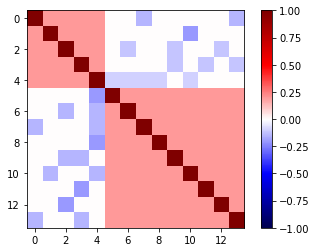

In [29]:
showdata(B,symmetry=True)

In [33]:
mX.is_Dstable(B_zero_delta)

False

In [34]:
mX.is_Dstable(B_zero_rho)

False

In [41]:
minVs = mX.is_Dstable(B_zero_rho, maxiter=1000,fullresult=True)
[-minV['fun'] for minV in minVs]

[2959094646156799.0,
 2914357657900135.5,
 3237286614316216.5,
 3173204250974098.5,
 2962690686178882.5]

In [44]:
mX.is_Lyapunovstable(B)

False

In [42]:

D = B_zero_rho.copy()
for _ in range(20):
    print(np.max(np.real(np.linalg.eigvals(np.dot(np.diag(np.random.rand(D.shape[0])*10*np.max(D)),D)))))


9.943575637082727
9.242236468436857
8.067348820864543
9.996471117941121
9.53991871984812
8.815280195660584
7.105889266069982
9.914314659152474
9.330305890688061
9.999731503120909
8.999605809788486
9.80739938501647
9.972613631328498
9.715428312010674
9.260419982885956
9.550696562538322
9.454549964730695
9.573196489424934
8.866524406011356
9.993486291665022
